In [3]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [66]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")

In [16]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../Project/gaussian_filter_image/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

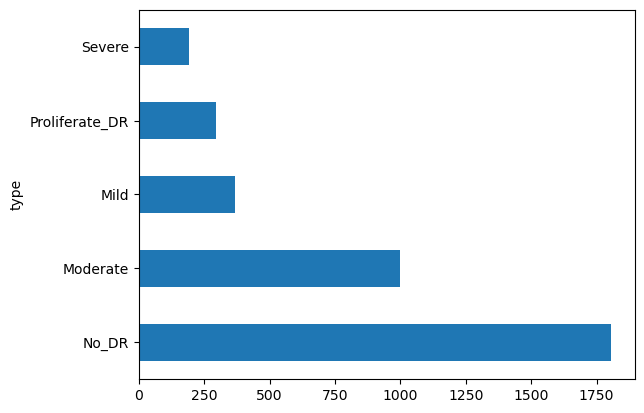

In [17]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

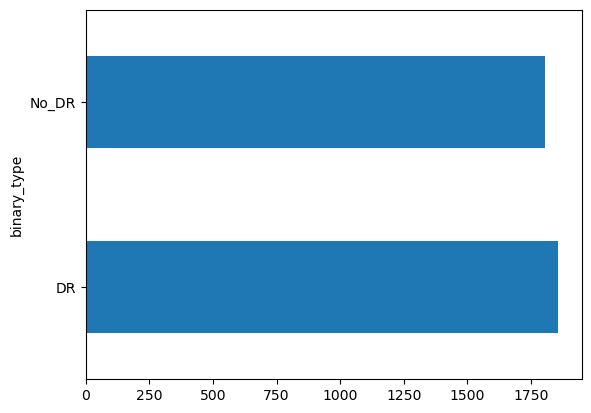

In [18]:
df['binary_type'].value_counts().plot(kind='barh')

In [19]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [20]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [24]:
# Copy images to respective working directory
src_dir = r'../Project/gaussian_filter_image/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [25]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [27]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])


history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

C:\Users\Tulasi Jena\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - acc: 0.8183 - loss: 0.4417 - val_acc: 0.5073 - val_loss: 0.7626
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - acc: 0.8871 - loss: 0.2610 - val_acc: 0.5073 - val_loss: 0.8625
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - acc: 0.9189 - loss: 0.2186 - val_acc: 0.5091 - val_loss: 0.7321
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - acc: 0.9272 - loss: 0.2084 - val_acc: 0.6473 - val_loss: 0.5299
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - acc: 0.9224 - loss: 0.2129 - val_acc: 0.6818 - val_loss: 0.4524
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - acc: 0.9393 - loss: 0.1945 - val_acc: 0.8418 - val_loss: 0.3375
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 324ms/step - acc: 0.9452 - loss: 0.1799 - val_acc: 0.9091 - val_loss: 0.2450
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 322ms/step - acc: 0.9461 - loss: 0.1687 - val_acc: 0.9109 - val_loss: 0.2052
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/

In [30]:
model.save('64x3-CNN.keras')

In [32]:
loss, acc = model.evaluate(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - acc: 0.9209 - loss: 0.2226
Accuracy:  0.9254545569419861


***Testing***

In [34]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 100.9 kB/s eta 0:06:25
   ---------------------------------------- 0.1/38.8 MB 327.7 kB/s eta 0:01:59
   ---------------------------------------- 0.1/38.8 MB 327.7 kB/s eta 0:01:59
   ---------------------------------------- 0.1/38.8 MB 387.0 kB/s eta 0:01:41
   ---------------------------------------- 0.2/38.8 MB 398.2 kB/s eta 0:01:38
   ---------------------------------------- 0.2/38.8 MB 398.2 kB/s eta 0:01:38
   -----------------------------

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.keras")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No Diabetic Ratinopathy')
    else:
        print('Diabetic Ratinopathy')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
DR


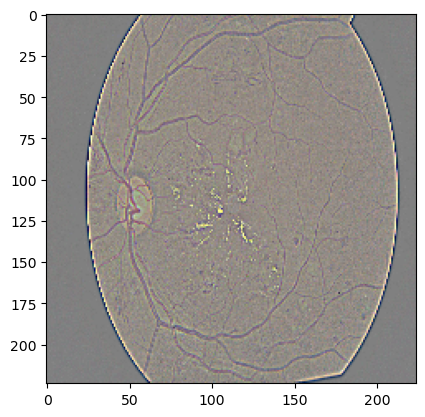

In [ ]:
predict_class(r'C:\Users\Tulasi Jena\Project\1ab3f1c71a5f.png')

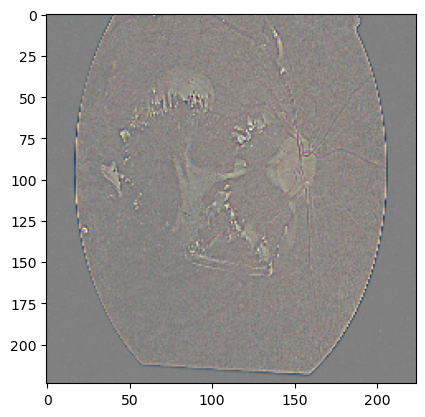

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
DR


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_class(path):
    # Load the image from the specified path
    img = cv2.imread(path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Could not load image from path '{path}'. Please check the path.")
        return

    # Convert the image from BGR to RGB
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the target size for the model
    RGBImg = cv2.resize(RGBImg, (224, 224))
    
    # Show the image
    plt.imshow(RGBImg)
    plt.show()

    # Normalize the image pixel values
    image = np.array(RGBImg) / 255.0

    # Load the trained model
    try:
        new_model = tf.keras.models.load_model("64x3-CNN.keras")
    except Exception as e:
        print(f"Error: Failed to load model. {str(e)}")
        return

    # Predict the class of the image
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)
    
    # Output the result
    if per == 1:
        print('No DR')
    else:
        print('DR')

# Call the function with the image path
predict_class(r'C:\Users\Tulasi Jena\Project\gaussian_filter_image\gaussian_filtered_images\Proliferate_DR\1a7e3356b39c.png')


In [ ]:
import os

print("Current working directory:", os.getcwd())
print("Image path:", os.path.exists(r'C:\Users\Tulasi Jena\Project\1ab3f1c71a5f.png'))


Current working directory: C:\Users\Tulasi Jena\Project
Image path: True


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
No DR


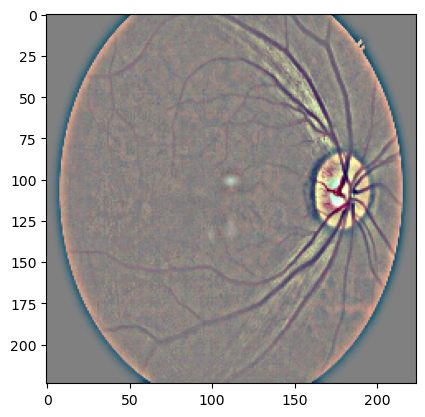

In [ ]:

# Call the function with the image path
predict_class(r'C:\Users\Tulasi Jena\Project\0b00f8a77510.png')